In [1]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

C:\Users\ddiaz\AppData\Local\Continuum\Anaconda2\envs\Py3.5\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [28]:
sns.set(style="white", color_codes=True)

In [2]:
data = pd.read_csv('DF_for_fitting.csv')

In [3]:
data.head()

,plot_id,subplot_id,measyear,tree_cn,tree_id,dbh,dg_in,diamincr_mm,MAT,MWMT,...,DD_18,variant,location,slope,aspect,elev,bal,cr,ccf,ba
0,5931423010901,5931430010901,2004,5931443010901,101,44.5,1.2,30.48,5.550000,15.627273,...,4555.227273,WC,605,0.95,4.625123,3700,0.0,0.45,50.0,61.933283
1,5931423010901,5931432010901,2004,5931489010901,124,29.2,1.1,27.94,5.550000,15.627273,...,4555.227273,WC,605,0.95,5.585054,3700,22.0,0.40,100.0,114.766495
2,5936567010901,5936575010901,2004,5936598010901,102,21.0,1.3,33.02,5.972727,18.486364,...,4460.272727,BM,616,0.45,2.775074,5900,0.0,0.90,28.0,25.491535
3,5936567010901,5936577010901,2004,5936610010901,112,20.0,2.4,60.96,5.972727,18.486364,...,4460.272727,BM,616,0.49,5.026548,5900,15.0,0.80,37.0,33.913766
4,5936567010901,5936578010901,2004,5936618010901,116,24.5,0.6,15.24,5.972727,18.486364,...,4460.272727,BM,616,0.45,2.443461,5900,0.0,0.90,7.0,5.758093


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36415 entries, 0 to 36414
Data columns (total 32 columns):
plot_id        36415 non-null int64
subplot_id     36415 non-null int64
measyear       36415 non-null int64
tree_cn        36415 non-null int64
tree_id        36415 non-null int64
dbh            36415 non-null float64
dg_in          36415 non-null float64
diamincr_mm    36415 non-null float64
MAT            36415 non-null float64
MWMT           36415 non-null float64
MCMT           36415 non-null float64
MAP            36415 non-null float64
AHM            36415 non-null float64
SHM            36415 non-null float64
MAR            36415 non-null float64
RH             36415 non-null float64
CMD            36415 non-null float64
Eref           36415 non-null float64
PAS            36415 non-null float64
NFFD           36415 non-null float64
DD5            36415 non-null float64
DD18           36415 non-null float64
DD_18          36415 non-null float64
variant        36415 non-nu

In [5]:
# Make some data transformations to fit GLM
data['DDS'] = ((data.dg_in)**2)
data['LOGDBH'] = np.log(data.dbh)
data['DBHSQ'] = (data.dbh**2)
data['BALDBH'] = (data.bal/np.log(data.dbh+1))
data['SLOPECOSASP'] = (data.slope * np.cos(data.aspect))
data['SLOPESINASP'] = (data.slope * np.sin(data.aspect))
data['SLOPESQ'] = (data.slope**2)
data['LOGMAT10'] = (np.log(data.MAT+10))
data['LOGMAP'] = (np.log(data.MAP))

In [6]:
# run a Random Forests regression model, allow 12 splits in each tree
regr = RandomForestRegressor(n_estimators=1000, max_depth=12, oob_score=True)
Xcols = ['dbh', 'bal', 'slope', 'aspect', 'elev', 'cr', 'ba', 'MAT', 'MAP']
#DBH, BAL, SLOPE, ASPECT, ELEV, CR, BA, MAT, MAP], axis=1)
regr.fit(X=data[Xcols], y=data.DDS)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [7]:
regr.oob_score_ # Random Forests R2 value on out-of-bag data

0.49458023001776563

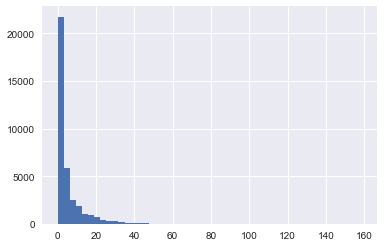

In [9]:
data.DDS.hist(bins=50);

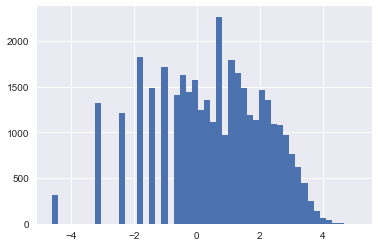

In [10]:
np.log(data.DDS).hist(bins=50);

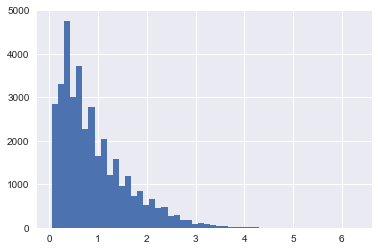

In [11]:
((data.dg_in)/2).hist(bins=50);

In [12]:
formula = 'DDS ~ LOGDBH + DBHSQ + BALDBH + SLOPECOSASP + SLOPESINASP + slope + SLOPESQ + elev + cr + ba + LOGMAT10 + LOGMAP'
base_model = smf.glm(formula=formula, data=data, family=sm.families.Gaussian(sm.families.links.log)).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    DDS   No. Observations:                36415
Model:                            GLM   Df Residuals:                    36402
Model Family:                Gaussian   Df Model:                           12
Link Function:                    log   Scale:                    37.712482838
Method:                          IRLS   Log-Likelihood:            -1.1776e+05
Date:                Tue, 12 Dec 2017   Deviance:                   1.3728e+06
Time:                        14:34:56   Pearson chi2:                 1.37e+06
No. Iterations:                    16                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.1931      0.200    -20.931      0.000      -4.586      -3.800
LOGDBH          0.4655      0.022     21.537      0.000       0.423       0.508
DBHSQ          -0.0013    3.9e-05    -33.874      0.000      -0.001      -0.001
BALDBH         -0.0473      0.001    -36.910      0.000      -0.050      -0.045
SLOPECOSASP    -0.0207      0.016     -1.296      0.195      -0.052       0.011
SLOPESINASP    -0.0914      0.016     -5.775      0.000      -0.122      -0.060
slope           0.4155      0.062      6.714      0.000       0.294       0.537
SLOPESQ        -1.0615      0.076    -13.917      0.000      -1.211      -0.912
elev           -0.0002   4.49e-06    -51.461      0.000      -0.000      -0.000
cr              2.0413      0.028     72.221      0.000       1.986       2.097
ba             -0.0013      0.000     -3.787      0.000      -0.002      -0.001
LOGMAT10        0.5542      0.055      9.990      0.000       0.446       0.663
LOGMAP          0.4593      0.010     44.871      0.000       0.439       0.479
===============================================================================
"""

In [40]:
formula = 'DDS ~ LOGDBH + DBHSQ + BALDBH + SLOPECOSASP + SLOPESINASP + slope + SLOPESQ + elev + cr + ba'
gaussNoClim_model = smf.glm(formula=formula, data=data, family=sm.families.Gaussian(sm.families.links.log)).fit()
gaussNoClim_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    DDS   No. Observations:                36415
Model:                            GLM   Df Residuals:                    36404
Model Family:                Gaussian   Df Model:                           10
Link Function:                    log   Scale:                   40.3274135177
Method:                          IRLS   Log-Likelihood:            -1.1898e+05
Date:                Tue, 12 Dec 2017   Deviance:                   1.4681e+06
Time:                        16:26:52   Pearson chi2:                 1.47e+06
No. Iterations:                    19                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0721      0.058     18.597      0.000       0.959       1.185
LOGDBH          0.3896      0.023     16.955      0.000       0.345       0.435
DBHSQ          -0.0014   4.38e-05    -32.200      0.000      -0.001      -0.001
BALDBH         -0.0541      0.001    -40.528      0.000      -0.057      -0.051
SLOPECOSASP    -0.0760      0.017     -4.491      0.000      -0.109      -0.043
SLOPESINASP    -0.1150      0.017     -6.950      0.000      -0.147      -0.083
slope           0.4431      0.065      6.860      0.000       0.316       0.570
SLOPESQ        -0.8762      0.080    -11.002      0.000      -1.032      -0.720
elev           -0.0003   3.71e-06    -88.311      0.000      -0.000      -0.000
cr              2.0790      0.029     70.888      0.000       2.022       2.136
ba              0.0021      0.000      6.201      0.000       0.001       0.003
===============================================================================
"""

In [13]:
formula = 'DDS ~ LOGDBH + DBHSQ + BALDBH + SLOPECOSASP + SLOPESINASP + slope + SLOPESQ + elev + cr + ba + LOGMAT10 + LOGMAP'
gamma_model = smf.glm(formula=formula, data=data, family=sm.families.Gamma(sm.families.links.log)).fit()
gamma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    DDS   No. Observations:                36415
Model:                            GLM   Df Residuals:                    36402
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                   3.05007246161
Method:                          IRLS   Log-Likelihood:                -88268.
Date:                Tue, 12 Dec 2017   Deviance:                       46830.
Time:                        14:35:03   Pearson chi2:                 1.11e+05
No. Iterations:                   100                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -7.2784      0.308    -23.652      0.000      -7.882      -6.675
LOGDBH         -0.0589      0.030     -1.975      0.048      -0.117      -0.000
DBHSQ          -0.0004   2.47e-05    -17.617      0.000      -0.000      -0.000
BALDBH         -0.0521      0.002    -33.380      0.000      -0.055      -0.049
SLOPECOSASP    -0.0659      0.029     -2.270      0.023      -0.123      -0.009
SLOPESINASP    -0.0281      0.028     -0.997      0.319      -0.083       0.027
slope          -0.5769      0.122     -4.745      0.000      -0.815      -0.339
SLOPESQ        -0.2634      0.132     -1.996      0.046      -0.522      -0.005
elev           -0.0002   8.71e-06    -24.381      0.000      -0.000      -0.000
cr              2.5788      0.051     50.385      0.000       2.478       2.679
ba              0.0007      0.001      1.232      0.218      -0.000       0.002
LOGMAT10        1.5792      0.093     16.989      0.000       1.397       1.761
LOGMAP          0.5818      0.019     31.065      0.000       0.545       0.618
===============================================================================
"""

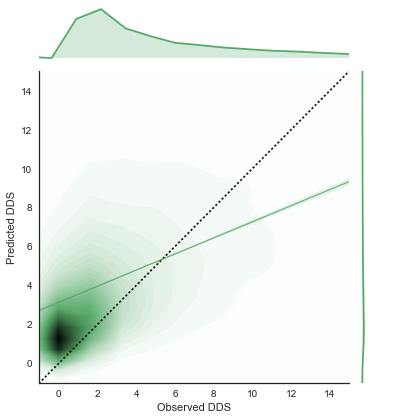

In [39]:
observed = data.DDS
predicted = pd.Series(base_model.mu)
g = sns.jointplot(observed, predicted, kind='kde', color='g', xlim=(-1,15), ylim=(-1,15), stat_func = None, joint_kws={'n_levels':50})
g.ax_joint.plot([-100,100], [-100,100], color='k', linestyle=':')
sns.regplot(observed, predicted, ax=g.ax_joint, line_kws={'ls':'-' ,'color':'g', 'lw':1}, scatter=False)
g.ax_joint.set_xlabel('Observed DDS')
g.ax_joint.set_ylabel('Predicted DDS')
plt.savefig('DDS_base_model.png');

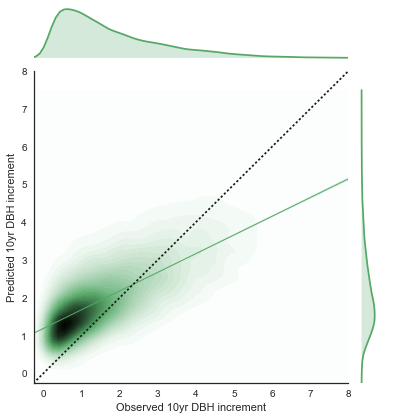

In [38]:
observed = np.sqrt(data.DDS)
predicted = pd.Series(np.sqrt(base_model.mu))
g = sns.jointplot(observed, predicted, kind='kde', color='g', xlim=(-0.25,8), ylim=(-0.25,8), stat_func = None, joint_kws={'n_levels':50})
sns.regplot(observed, predicted, ax=g.ax_joint, line_kws={'color':'g', 'lw':1}, scatter=False)
g.ax_joint.plot([-100,100], [-100,100], color='k', linestyle=':')
g.ax_joint.set_xlabel('Observed 10yr DBH increment')
g.ax_joint.set_ylabel('Predicted 10yr DBH increment')
plt.savefig('DBHinc_base_model.png');

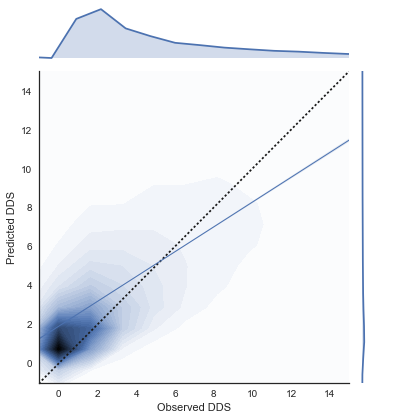

In [37]:
observed = data.DDS
predicted = pd.Series(regr.predict(X=data[Xcols]))
g = sns.jointplot(observed, predicted, kind='kde', color='b', xlim=(-1,15), ylim=(-1,15), stat_func = None, joint_kws={'n_levels':50})
g.ax_joint.plot([-100,100], [-100,100], color='k', linestyle=':')
sns.regplot(observed, predicted, ax=g.ax_joint, line_kws={'ls':'-' ,'color':'b', 'lw':1}, scatter=False)
g.ax_joint.set_xlabel('Observed DDS')
g.ax_joint.set_ylabel('Predicted DDS')
plt.savefig('DDS_RF_model.png');

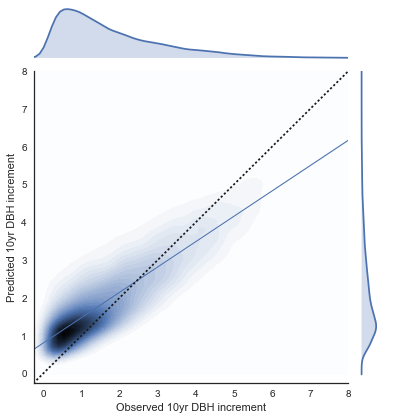

In [36]:
observed = np.sqrt(data.DDS)
predicted = pd.Series(np.sqrt(regr.predict(X=data[Xcols])))
g = sns.jointplot(observed, predicted, kind='kde', color='b', xlim=(-0.25,8), ylim=(-0.25,8), stat_func = None, joint_kws={'n_levels':50})
sns.regplot(observed, predicted, ax=g.ax_joint, line_kws={'color':'b', 'lw':1}, scatter=False)
g.ax_joint.plot([-100,100], [-100,100], color='k', linestyle=':')
g.ax_joint.set_xlabel('Observed 10yr DBH increment')
g.ax_joint.set_ylabel('Predicted 10yr DBH increment')
plt.savefig('DBHinc_RF_model.png');

In [17]:
def nash_sutcliffe(observed, predicted):
    return 1 - ((predicted - observed)**2).sum()/((observed - observed.mean())**2).sum()
def r_squared(observed, predicted):
    r = ((observed - observed.mean())*(predicted - predicted.mean())).sum()/ \
    ((np.sqrt(((observed - observed.mean())**2).sum()))*(np.sqrt(((predicted - predicted.mean())**2).sum())))
    return r**2
def RMSE(observed, predicted):
    return np.sqrt(((predicted - observed)**2).sum()/len(predicted))

In [41]:
# print(nash_sutcliffe(data.DDS, base_model.mu), nash_sutcliffe(data.DDS, gamma_model.mu))
print(r_squared(data.DDS, base_model.mu), r_squared(data.DDS, gamma_model.mu), 
      r_squared(data.DDS, regr.predict(X=data[Xcols])), r_squared(data.DDS, gaussNoClim_model.mu))
print(RMSE(data.DDS, base_model.mu), RMSE(data.DDS, gamma_model.mu), 
      RMSE(data.DDS, regr.predict(X=data[Xcols])), RMSE(data.DDS, gaussNoClim_model.mu))
print(base_model.aic, gamma_model.aic, gaussNoClim_model.aic)
print(base_model.bic, gamma_model.bic, gaussNoClim_model.bic)


0.422189651693 0.385730022505 0.767844128417 0.381868510982
6.13995273941 6.43925335605 4.07346192708 6.3494276657
235540.421079 176562.518209 237979.694494
990489.202335 -335490.910143 1085737.55829


In [22]:
# Random Forest Regression feature importance scores
for x, y in zip(Xcols, regr.feature_importances_):
    print(x, y)

dbh 0.114538695104
bal 0.10827129594
slope 0.0511434417131
aspect 0.040737466594
elev 0.167571804076
cr 0.192092217978
ba 0.0789446283107
MAT 0.091940473517
MAP 0.154759976768
